# ML for Time Series

## A Unified Framework for Structured Graph Learning via Spectral Constraints

Baptiste Collet - Cyril Miras

## Experiments

### Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets as skd
import sklearn.metrics as skm
from learnGraphTopology import *

## Popular synthetic datasets

In [4]:
def dist_mat_exp_kernel(x, sigma=1, eps=1, k=None):
    n, d = x.shape
    dist_mat = np.zeros((n, n))
    for i in range(n):
        dist_mat[i] = np.exp(-np.linalg.norm(x[i] - x, axis=1)/eps)
    if not k is None:
        for i in range(n):
            k_th_nearest_dist = np.sort(dist_mat[i])[-k]
            dist_mat[i][dist_mat[i] < k_th_nearest_dist] = 0
        dist_mat = 0.5*(dist_mat + dist_mat.T)
    else:
        dist_mat[dist_mat<eps] = 0
    return dist_mat

We load the "two moons" dataset

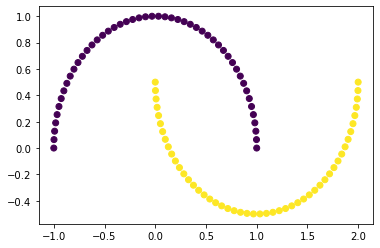

In [10]:
n_samples = 100
moons_data, moons_labels = skd.make_moons(n_samples=n_samples)
plt.scatter(moons_data.T[0], moons_data.T[1], c=moons_labels)
plt.show()

In [11]:
C_moons = dist_mat_exp_kernel(moons_data, sigma=1, eps=0.1)

In [12]:
res_moons = learn_k_component_graph(C_moons, k=2, maxiter=2000) #2000 or more in reality

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 801.66it/s]


In [14]:
score_moons = np.linalg.eigh(res_moons["Laplacian"])[1][:, 1]
print("AUC score of the spectral classifier", skm.roc_auc_score(moons_labels, score_moons))

AUC score of the spectral classifier 0.6248


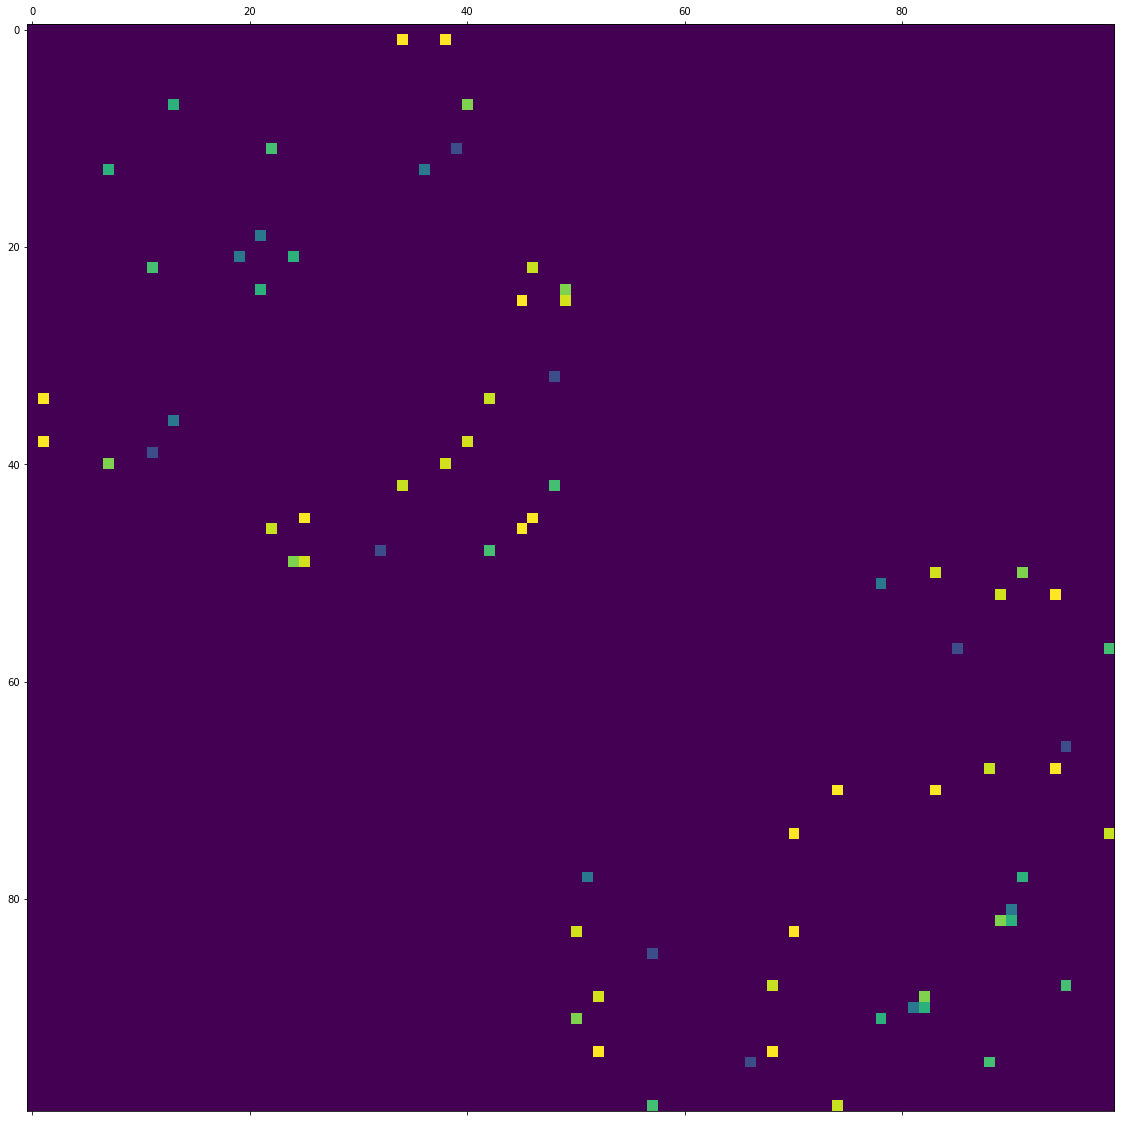

In [15]:
id_moons = np.argsort(moons_labels)
fig = plt.figure(figsize=(20, 20))
plt.matshow(res_moons["Adjacency"][id_moons][:, id_moons], fignum=0)
plt.show()

We load the "two circles" dataset

In [29]:
def at_least_k_component(L,k):
    la,M=np.linalg.eigh(L)
    la[:k] = 0
    return M@np.diag(la)@M.T

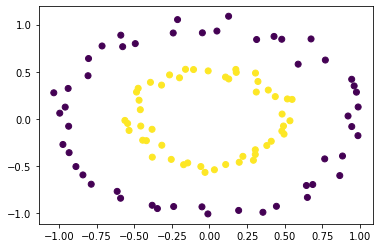

In [55]:
n_samples = 100
circles_data, circles_labels = skd.make_circles(n_samples=n_samples,noise=0.05,factor=0.5)
plt.scatter(circles_data.T[0], circles_data.T[1], c=circles_labels)
plt.show()

In [56]:
C_circles = dist_mat_exp_kernel(circles_data, k=7,sigma=0.1)
res_circles = learn_k_component_graph(C_circles, k=2, maxiter=10000) #2000 or more in reality

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 770.81it/s]


In [51]:
print(res_circles["convergence"])

False


In [30]:
#res_circles["Laplacian"]=at_least_k_component(res_circles["Laplacian"],k=2)

In [57]:
print(nb_connected_component(res_circles["Laplacian"]))

2


In [28]:
print(np.array([[0.3,0.02],[0.02,0.3]]).round(1))
np.linalg.eigh(res_circles["Laplacian"])[0][1]

[[0.3 0. ]
 [0.  0.3]]


0.014670559045444825

In [58]:
score_circles = np.linalg.eigh(res_circles["Laplacian"])[1][:, 1]
print("AUC score of the spectral classifier", skm.roc_auc_score(circles_labels, score_circles))

AUC score of the spectral classifier 0.0


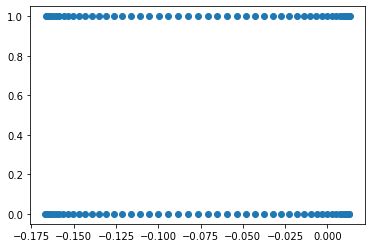

In [33]:
plt.scatter(score_circles, circles_labels)

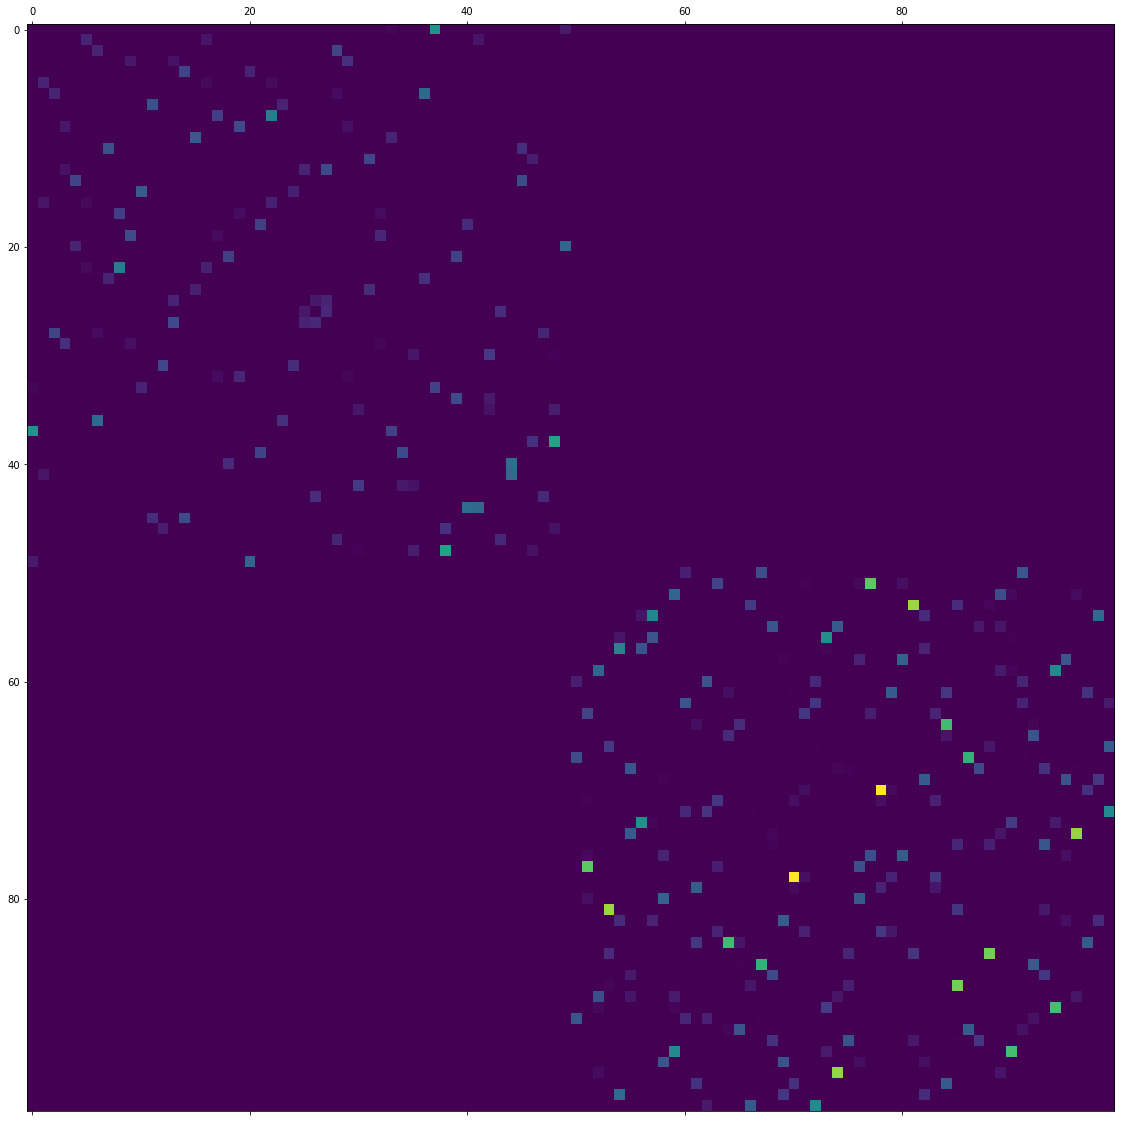

In [59]:
id_circles = np.argsort(circles_labels)
fig = plt.figure(figsize=(20, 20))
plt.matshow(res_circles["Adjacency"][id_circles][:, id_circles], fignum=0)
plt.show()

In [39]:
A=res_circles["Adjacency"][id_circles][:, id_circles]
print(np.max(A[60:,:40]),np.max(A[:40,60:]))
print(np.max(A))

1.2291195212897192 1.2291195212897192
4.529841298153861


In [77]:
def helix_3D(n_samples, h=20, angle=np.pi/2):
    labels=np.array([0]*(n_samples//2)+[1]*((n_samples+1)//2))
    np.random.shuffle(labels)
    ha = np.random.rand(n_samples)*h
    return np.array([[np.cos(a+b),np.sin(a+b),a] for a,b in zip(ha,labels)]),labels

In [78]:
def three_circles(n_samples,factor=0.5):
    labels=np.zeros([n_samples])
    labels[-n_samples//3:]=2
    labels[n_samples//3:-n_samples//3]=1
    np.random.shuffle(labels)
    angles= np.random.rand(n_samples)*2*np.pi
    print(angles,labels)
    return np.array([[np.cos(a)*factor**b,np.sin(a)*factor**b] for a,b in zip(angles,labels)]),labels

In [79]:
print(three_circles(6))

[2.24617561 4.00626627 2.1131063  1.34874474 1.18353133 6.01865088] [0. 2. 1. 2. 1. 0.]
(array([[-0.62519338,  0.78046988],
       [-0.16222212, -0.19022088],
       [-0.25805795,  0.42825938],
       [ 0.05505782,  0.24386192],
       [ 0.18882868,  0.46297271],
       [ 0.96521433, -0.26145992]]), array([0., 2., 1., 2., 1., 0.]))


## Gene dataset

This dataset come from https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq#

It represents 801 patients with cancers of 5 different types

The features of the data are RNA-Seq gene expression levels

The label is the tumor type

To make the code work, download the dataset,extract it and save data and labels in the folder ./data/genes/

In [80]:
gene_df = pd.read_csv("data/genes/data.csv")
gene_df = gene_df[gene_df.columns[1:]]
gene_df

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.000000
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.000000
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.000000
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.000000
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,0.0,1.865642,2.718197,7.350099,10.006003,0.0,6.764792,0.496922,0.0,0.0,...,6.088133,9.118313,10.004852,4.484415,9.614701,12.031267,9.813063,10.092770,8.819269,0.000000
797,0.0,3.942955,4.453807,6.346597,10.056868,0.0,7.320331,0.000000,0.0,0.0,...,6.371876,9.623335,9.823921,6.555327,9.064002,11.633422,10.317266,8.745983,9.659081,0.000000
798,0.0,3.249582,3.707492,8.185901,9.504082,0.0,7.536589,1.811101,0.0,0.0,...,5.719386,8.610704,10.485517,3.589763,9.350636,12.180944,10.681194,9.466711,4.677458,0.586693
799,0.0,2.590339,2.787976,7.318624,9.987136,0.0,9.213464,0.000000,0.0,0.0,...,5.785237,8.605387,11.004677,4.745888,9.626383,11.198279,10.335513,10.400581,5.718751,0.000000


In [81]:
gene_labels = pd.read_csv("data/genes/labels.csv")
gene_labels = gene_labels[gene_labels.columns[1:]]
gene_labels

,Class
0,PRAD
1,LUAD
2,PRAD
3,PRAD
4,BRCA
...,...
796,BRCA
797,LUAD
798,COAD
799,PRAD


The goal is to model the distribution with a $k$ component graph, in order to clusetr the data into $k$ classes. As there are $k=5$ classes in reality, we try the algorithm with this value.

In [82]:
C = np.cov(gene_df.values)

In [83]:
res_genes = learn_k_component_graph(C, k=5, maxiter=2000) #2000 or more in reality

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:30<00:00, 22.20it/s]


Then, we reorganise the matrix according to their labels to see visually if the components that should be connected are effectively connected.

In [84]:
id_genes = np.argsort(gene_labels.values.squeeze())

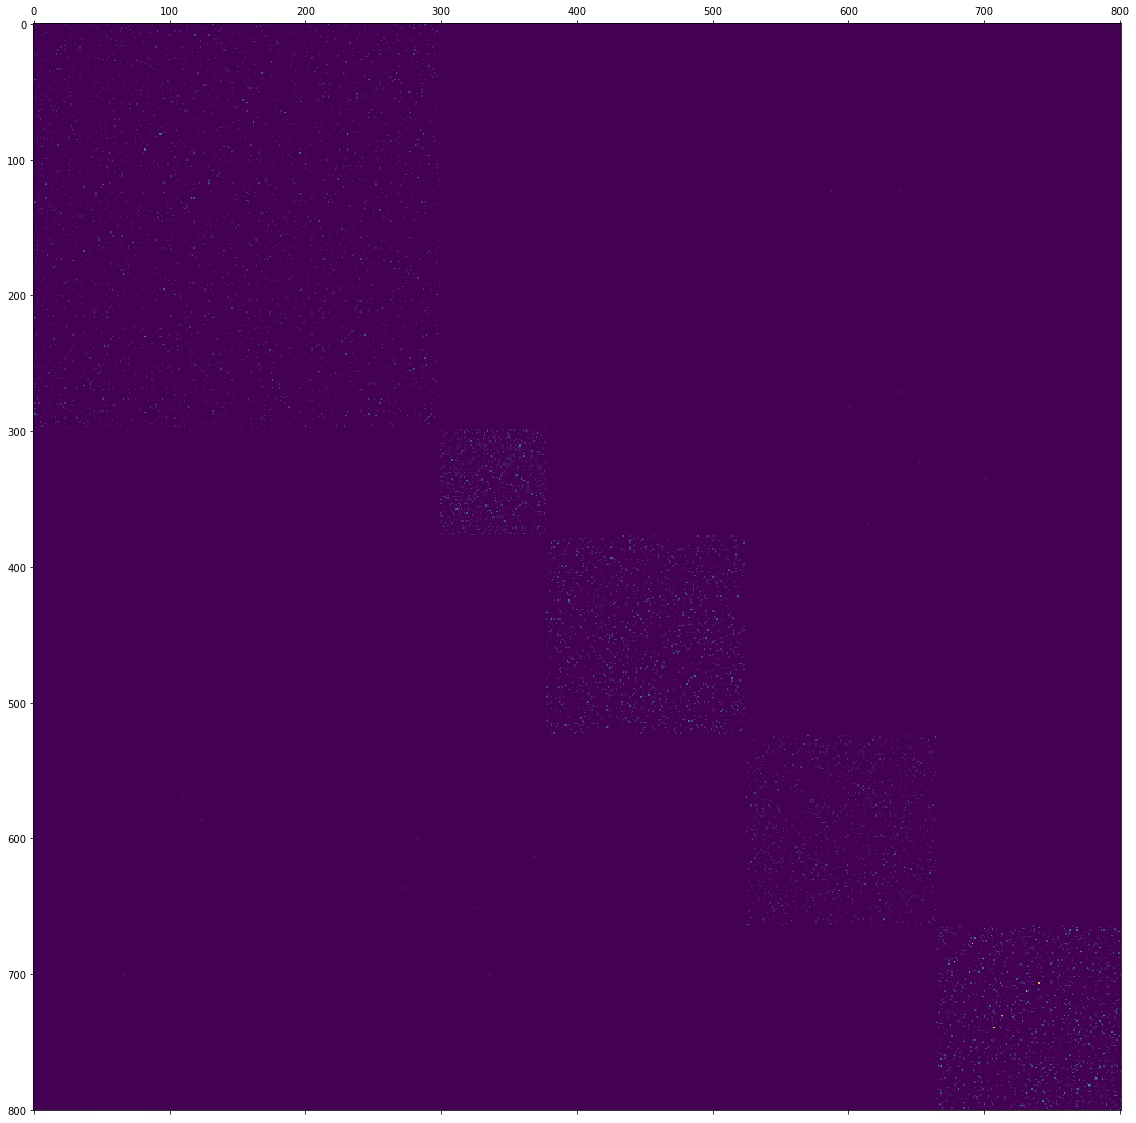

In [85]:
fig = plt.figure(figsize=(20, 20))
plt.matshow(res_genes["Adjacency"][id_genes][:, id_genes], fignum=0)
plt.show()

In [87]:
print(np.sort(np.linalg.eigh(res_genes["Laplacian"])[0]))

[4.70513432e-18 4.01387939e-17 2.02153207e-16 5.35030498e-16
 1.03713146e-15 5.14205657e-03 8.32408429e-03 1.11138719e-02
 2.19243252e-02 6.84623548e-02 1.77883621e-01 1.90857229e-01
 2.07263236e-01 2.28828434e-01 2.32370308e-01 2.45290063e-01
 2.60273495e-01 2.67629548e-01 2.87556609e-01 2.97822793e-01
 3.09004897e-01 3.26125721e-01 3.34110646e-01 3.40222187e-01
 3.49498427e-01 3.82445743e-01 3.88065647e-01 3.97206370e-01
 3.99068500e-01 4.02393957e-01 4.13682559e-01 4.16894823e-01
 4.38327408e-01 4.44548216e-01 4.46224265e-01 4.53301958e-01
 4.55733094e-01 4.63011723e-01 4.71120056e-01 4.72551672e-01
 4.75732584e-01 4.81634017e-01 4.85649661e-01 4.90576130e-01
 4.96848313e-01 4.98475371e-01 5.00137562e-01 5.04841524e-01
 5.11229173e-01 5.16727881e-01 5.21237649e-01 5.31631602e-01
 5.35150282e-01 5.39813703e-01 5.47285708e-01 5.50371415e-01
 5.52451975e-01 5.60832441e-01 5.65106454e-01 5.71763808e-01
 5.73407912e-01 5.82529260e-01 5.83937510e-01 5.87591950e-01
 5.96068065e-01 6.017311

# keyword dataset

In [88]:
act_df = pd.read_csv('data/keyword_activity/ALL.csv', skiprows=9, sep=';')

In [89]:
print(act_df)

       # activity_0   activity_1   activity_2   activity_3   activity_4  \
0            1002.0        925.0       1105.0        973.0        889.0   
1             805.0        805.0       1143.0       1121.0        954.0   
2             542.0        473.0        504.0        626.0        647.0   
3            1406.0        947.0        363.0        180.0         92.0   
4             100.0        184.0         79.0        162.0         99.0   
...             ...          ...          ...          ...          ...   
76342         772.0        359.0        884.0        529.0        838.0   
76343         819.0        708.0        753.0        845.0        780.0   
76344         538.0        600.0        603.0        583.0        660.0   
76345         582.0        743.0       1002.0       1031.0        981.0   
76346         863.0        983.0        900.0       1168.0          0.0   

        activity_5   activity_6   number_of_users_0   number_of_users_1  \
0            939.0      

# sensor displacement

data available at https://archive.ics.uci.edu/ml/machine-learning-databases/00305/

In [2]:
from os import listdir
location = "data/realistic_sensor_displacement"
for filename in listdir(location)[:1]:
    file=(pd.read_csv(location+'/'+filename, skiprows=0, sep='\s+'))

In [3]:
l=file.values

print(l.shape)

(179809, 120)


In [4]:
l=l[:,2:-1]

In [7]:
di=learn_k_component_graph(l.T,k=5,maxiter=10000)

 46%|█████████████████████████████████████████████████████████████████████████▎                                                                                      | 4579/10000 [00:08<00:10, 532.42it/s]


In [134]:
V=np.linalg.eigh(di["Laplacian"])[1]

In [135]:
ordre=np.argsort(V.T[1,:])
print(ordre.shape)
print(ordre)

(117,)
[ 52  53   2  26  13  91  65  78  44  57  28  49 110 114  11 116  51  45
  25 105  27  70   5  95   3  64  16   4  37  35  68  46  29   7 113 106
 107  12  81  18  31  96  17  43  72  83 101  48  56 109  42  90  86  10
 111   6  47   9  98 112  88  99  33  30  77  92  73  36  60  69  85  55
  21 103  22  82 108  24  67  62  38  20  63  94  50 115  40  34  75  93
  66   8  79  80  59   1  71  32  39  14  41 104  19  76  54  74   0  87
  23 100  84  61  89 102  97  15  58]


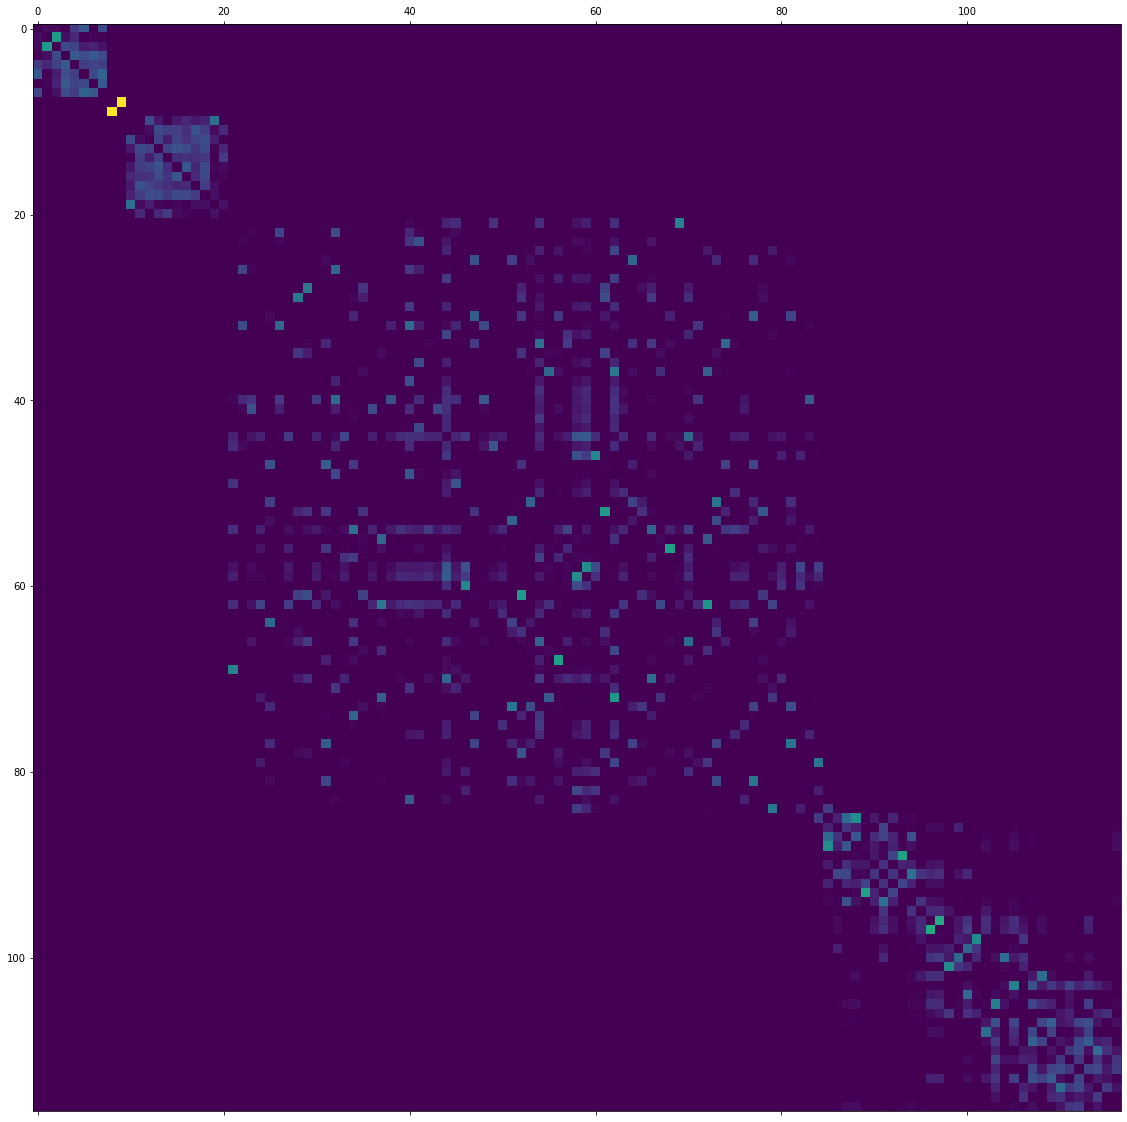

In [136]:
fig = plt.figure(figsize=(20, 20))
plt.matshow(di["Adjacency"][ordre][:,ordre], fignum=0)
plt.show()

In [7]:
print(di["convergence"])

False


In [8]:
print(np.sort(np.linalg.eigh(di["Laplacian"])[0])[:10])

[-1.66373329e-16  4.83570725e-16  6.62637779e-16  3.12312050e-04
  4.24257259e-03  6.92916984e-02  9.80451854e-02  1.75239480e-01
  1.90325887e-01  2.12890502e-01]


In [107]:
print(np.max(di["Laplacian"]))

2.969659142539227


In [142]:
def A_to_L(A):
    D=np.diag(np.sum(A,axis=0))
    return D-A

In [140]:
A=(di["Adjacency"])*(abs(di["Adjacency"])>10**-3)

In [143]:
L=A_to_L(A)